In [53]:
import pandas as pd
import networkx as nx
from  networkx.algorithms import  tree
import numpy as np
import pygmt
import matplotlib.pyplot as plt

In [54]:
from math import radians, degrees, sin, cos, asin, acos, sqrt

In [55]:
from unicodedata import normalize
def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')

In [56]:
def great_circle(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )
great_circle_f = np.vectorize(great_circle)

In [57]:
# Base de dados de Origem e Destino Gasolina Diese
df_gasol_diesel = pd.read_csv('matriz_origem_destino_gasolina_diesel_limpa.csv',sep=';',encoding='ANSI')

In [58]:
df_corredor_gasol_diesel = pd.read_csv('corredor_logistico_gasolina_diesel.csv',sep=';',encoding='ANSI')

In [59]:
# Base de dados de Rodovias e Hidrovias
df_rodo_hidro = pd.read_csv('Base_de_dados_ligacoes_rodoviarias_e_hidroviarias_2016.csv',sep=';',encoding='ANSI')

df_rodo_hidro['distancia'] = great_circle_f(np.array(df_rodo_hidro['Longitude_A']),
             np.array(df_rodo_hidro['Latitude_A']),
            np.array(df_rodo_hidro['Longitude_B']), 
            np.array(df_rodo_hidro['Latitude_B']))


In [60]:
df_rodo_CNT = pd.read_csv('qualidade_rodovias_CNT.csv',sep=';',encoding='ANSI')

In [61]:
df_hidro = df_rodo_hidro[df_rodo_hidro['Freq_Hidroviario'] > 0]

In [62]:
df_rodo = df_rodo_hidro[df_rodo_hidro['Freq_Rodoviario'] > 0]

In [63]:
df0 = df_rodo_hidro[['Longitude_A', 'Latitude_A','Longitude_B', 'Latitude_B']]
data_rodo_hidro = df0.to_numpy()

df0 = df_hidro[['Longitude_A', 'Latitude_A','Longitude_B', 'Latitude_B']]
data_hidro = df0.to_numpy()

df0 = df_rodo[['Longitude_A', 'Latitude_A','Longitude_B', 'Latitude_B']]
data_rodo = df0.to_numpy()

In [64]:
# Base de dados de Municipios
df_municipios = pd.read_csv('coordenadas_municipios.csv',sep=',',encoding='UTF-8')

# Removendo acentos e convertendo para maiscula
df_municipios['nome'] = df_municipios['nome'].apply(remover_acentos)
df_municipios['nome'] = df_municipios['nome'].str.upper()

# acrescenta duas colunas para facilitar o merge
df_municipios['Municipio Origem'] = df_municipios['nome']
df_municipios['Municipio de Destino'] = df_municipios['nome']
df_municipios.rename(columns = {'nome':'Municipio'}, inplace = True)

In [65]:
# Base de dados de Oleoduto
df_oleodutos = pd.read_csv('Oleoduto.csv',sep=';',encoding='UTF-8',skiprows = 5)

In [66]:
# Base de arestas dos oleodutos
teste = pd.merge(df_oleodutos, df_municipios, on=["Municipio Origem"], how="inner")
teste.rename(columns = {'Municipio de Destino_x':'Municipio de Destino'}, inplace = True)
df_oleodutos = pd.merge(teste, df_municipios, on=["Municipio de Destino"], how="inner")

df1 = df_oleodutos[['longitude_x', 'latitude_x','longitude_y', 'latitude_y']]
data_oleodutos = df1.to_numpy()

In [67]:
# Trecho auxiliar para os tipos de origem e destino
print(df_oleodutos['Tipo'].unique())
print(' ===== ')
print(df_oleodutos['Tipo de origem '].unique())
print(' ===== ')
print(df_oleodutos['Tipo do destino '].unique())

['Portuário' 'Transferência' 'Transporte']
 ===== 
['TERMINAL' 'REFINARIA' 'BASES DO RAMO DE COMBUSTÍVEIS'
 'BASES DO RAMO DE LIQUEFEITOS' 'PLANTA DE CPQ' 'ESTAÇÃO DE BOMBEAMENTO'
 'PONTO DE REVENDA DE GLP'
 'PLANTA DE PRODUÇÃO DE ÓLEO LUBRIFICANTE ACABADO'
 'PÓLO DE PROCESSAMENTO DE GÁS NATURAL' 'OLEODUTO'
 'BASES DO RAMO DE SOLVENTES' 'PLANTA DE PRODUCAO DE ETANOL']
 ===== 
['TERMINAL' 'BASES DO RAMO DE COMBUSTÍVEIS' 'BASES DO RAMO DE LIQUEFEITOS'
 'REFINARIA' 'ESTAÇÃO DE BOMBEAMENTO' 'PONTO DE REVENDA DE GLP'
 'PLANTA DE PRODUÇÃO DE ÓLEO LUBRIFICANTE ACABADO' 'OLEODUTO'
 'BASES DO RAMO DE AVIAÇÃO' 'PÓLO DE PROCESSAMENTO DE GÁS NATURAL'
 'PLANTA DE CPQ' 'BASES DO RAMO DE SOLVENTES' 'BASES DO RAMO DE TRR'
 'COMÉRCIO EXTERIOR' 'PONTO DE ABASTECIMENTO']


In [68]:
# Dicionario com os tipos de origem e destino da base de Oleodutos
oleoduto_cod = {
    'TERMINAL': 'TERM', 'REFINARIA': 'REF', 'BASES DO RAMO DE COMBUSTÍVEIS': 'COMB',
 'BASES DO RAMO DE LIQUEFEITOS': 'LIQ', 'PLANTA DE CPQ': 'CPQ', 'ESTAÇÃO DE BOMBEAMENTO': 'BOMB',
 'PONTO DE REVENDA DE GLP': 'GLP',
 'PLANTA DE PRODUÇÃO DE ÓLEO LUBRIFICANTE ACABADO': 'LUB',
 'PÓLO DE PROCESSAMENTO DE GÁS NATURAL': 'GN', 'OLEODUTO': 'DUTO',
 'BASES DO RAMO DE SOLVENTES':'SOLV' , 'PLANTA DE PRODUCAO DE ETANOL':'ETAN'
}

In [69]:
# Gera bases separadas para cada tipo de origem
origens_duto = {}
for origem in df_oleodutos['Tipo de origem '].unique():
    df_origem = df_oleodutos[df_oleodutos['Tipo de origem '] == origem]
    df1 = df_origem[['longitude_x', 'latitude_x']]
    origens_duto[oleoduto_cod[origem]] = df1.drop_duplicates()

    # print(origem)
    # print(len(df1.drop_duplicates().index))


In [70]:
# Revendedores varejistas
df_varejo = pd.read_csv('dados-cadastrais-revendedores-varejistas-combustiveis-automoveis.csv', sep=';',encoding='UTF-8')
df_varejo.rename(columns = {'MUNICIPIO':'Municipio'}, inplace = True)
df_varejo = pd.merge(df_varejo, df_municipios, on=["Municipio"], how="inner")


In [71]:
df_rodo_CNT.rename(columns = {'Município inicial':'Municipio Origem'}, inplace = True)
df_rodo_CNT.rename(columns = {'Município final':'Municipio de Destino'}, inplace = True)

df_rodo_CNT['Municipio Origem'] = df_rodo_CNT['Municipio Origem'].apply(remover_acentos)
df_rodo_CNT['Municipio Origem'] = df_rodo_CNT['Municipio Origem'].str.upper()

df_rodo_CNT['Municipio de Destino'] = df_rodo_CNT['Municipio de Destino'].apply(remover_acentos)
df_rodo_CNT['Municipio de Destino'] = df_rodo_CNT['Municipio de Destino'].str.upper()

df_simples = df_rodo_CNT

# Base de arestas dos oleodutos
teste = pd.merge(df_simples, df_municipios, on=["Municipio Origem"], how="inner")
teste.rename(columns = {'Municipio de Destino_x':'Municipio de Destino'}, inplace = True)
df_simples = pd.merge(teste, df_municipios, on=["Municipio de Destino"], how="inner")

df1 = df_simples[['longitude_x', 'latitude_x','longitude_y', 'latitude_y']]
data_rodo_CNT_simples = df1.to_numpy()


In [117]:
df_corredor_gasol_diesel.rename(columns = {'MUNICIPIO ORIGEM':'Municipio Origem'}, inplace = True)
df_corredor_gasol_diesel.rename(columns = {'MUNICIPIO DESTINO':'Municipio de Destino'}, inplace = True)

df_corredor_gasol_diesel['Municipio Origem'] = df_corredor_gasol_diesel['Municipio Origem'].apply(remover_acentos)
df_corredor_gasol_diesel['Municipio Origem'] = df_corredor_gasol_diesel['Municipio Origem'].str.upper()

df_corredor_gasol_diesel['Municipio de Destino'] = df_corredor_gasol_diesel['Municipio de Destino'].apply(remover_acentos)
df_corredor_gasol_diesel['Municipio de Destino'] = df_corredor_gasol_diesel['Municipio de Destino'].str.upper()

df_simples = df_corredor_gasol_diesel

# Base de arestas dos oleodutos
teste = pd.merge(df_simples, df_municipios, on=["Municipio Origem"], how="inner")
teste.rename(columns = {'Municipio de Destino_x':'Municipio de Destino'}, inplace = True)
df_simples = pd.merge(teste, df_municipios, on=["Municipio de Destino"], how="inner")

df1 = df_simples[['longitude_x', 'latitude_x','longitude_y', 'latitude_y']]
data_corredor_gasol_diesel = df1.to_numpy()

ni = np.shape(data_corredor_gasol_diesel)[0]
nj = np.shape(data_corredor_gasol_diesel)[0]
data_corredor_gasol_diesel_pts = np.reshape(data_corredor_gasol_diesel,[ni*2,2])

In [116]:
df_gasol_diesel.rename(columns = {'MUNICIPIO ORIGEM':'Municipio Origem'}, inplace = True)
df_gasol_diesel.rename(columns = {'MUNICIPIO DESTINO':'Municipio de Destino'}, inplace = True)

df_gasol_diesel['Municipio Origem'] = df_gasol_diesel['Municipio Origem'].apply(remover_acentos)
df_gasol_diesel['Municipio Origem'] = df_gasol_diesel['Municipio Origem'].str.upper()

df_gasol_diesel['Municipio de Destino'] = df_gasol_diesel['Municipio de Destino'].apply(remover_acentos)
df_gasol_diesel['Municipio de Destino'] = df_gasol_diesel['Municipio de Destino'].str.upper()

df_simples = df_gasol_diesel

# Base de arestas dos oleodutos
teste = pd.merge(df_simples, df_municipios, on=["Municipio Origem"], how="inner")
teste.rename(columns = {'Municipio de Destino_x':'Municipio de Destino'}, inplace = True)
df_simples = pd.merge(teste, df_municipios, on=["Municipio de Destino"], how="inner")

df1 = df_simples[['longitude_x', 'latitude_x','longitude_y', 'latitude_y']]
data_gasol_diesel = df1.to_numpy()

ni = np.shape(data_gasol_diesel)[0]
nj = np.shape(data_gasol_diesel)[0]
data_gasol_diesel_pts = np.reshape(data_gasol_diesel,[ni*2,2])

In [74]:
print(df_rodo_CNT['Municipio Origem'][0])
print(df_varejo['Municipio Origem'][0])

DIONISIO CERQUEIRA
BREJO


In [75]:
# Contando o numero de postos por cidade
df_total_postos = df_varejo.groupby(['Municipio','latitude','longitude']).agg('count').reset_index()

In [76]:
# Distribuidores de Combustíveis Líquidos Autorizados ao Exercício da Atividade -
df_distro_combustivel = pd.read_csv('planilha-aea-filiais.csv',sep=';',encoding='ANSI')
df_distro_combustivel = pd.merge(df_distro_combustivel, df_municipios, on=["Municipio"], how="inner")

data_distro = df_distro_combustivel[['longitude','latitude']]

In [77]:
# Capacidade de Armazenagem de Terminais
df_terminais = pd.read_csv('capacidade-armazenagem-terminais.csv',sep=',',encoding='UTF-8')
df_terminais = pd.merge(df_terminais, df_municipios, on=["Municipio"], how="inner")


data_terminais = df_terminais[['longitude','latitude']]

In [78]:
#from_pandas_edgelist(df, source='source', target='target', edge_attr=None, create_using=None, edge_key=None)
G_rodo = nx.from_pandas_edgelist(df_rodo, 'NOMEMUN_A', 'NOMEMUN_B',['distancia'])
G_hidro = nx.from_pandas_edgelist(df_hidro, 'NOMEMUN_A', 'NOMEMUN_B',['distancia'])

In [79]:
T_rodo = tree.minimum_spanning_tree(G_rodo,algorithm='prim')
T_hidro = tree.minimum_spanning_tree(G_hidro,algorithm='prim')

In [80]:
df_simples = pd.DataFrame(T_rodo.edges, columns =['Municipio Origem', 'Municipio de Destino'])

df_simples['Municipio Origem'] = df_simples['Municipio Origem'].apply(remover_acentos)
df_simples['Municipio Origem'] = df_simples['Municipio Origem'].str.upper()

df_simples['Municipio de Destino'] = df_simples['Municipio de Destino'].apply(remover_acentos)
df_simples['Municipio de Destino'] = df_simples['Municipio de Destino'].str.upper()

# Base de arestas dos oleodutos
teste = pd.merge(df_simples, df_municipios, on=["Municipio Origem"], how="inner")
teste.rename(columns = {'Municipio de Destino_x':'Municipio de Destino'}, inplace = True)
df_simples = pd.merge(teste, df_municipios, on=["Municipio de Destino"], how="inner")

df1 = df_simples[['longitude_x', 'latitude_x','longitude_y', 'latitude_y']]
data_rodo_simples = df1.to_numpy()

# ==================================================================================================
df_simples = pd.DataFrame(T_hidro.edges, columns =['Municipio Origem', 'Municipio de Destino'])

df_simples['Municipio Origem'] = df_simples['Municipio Origem'].apply(remover_acentos)
df_simples['Municipio Origem'] = df_simples['Municipio Origem'].str.upper()

df_simples['Municipio de Destino'] = df_simples['Municipio de Destino'].apply(remover_acentos)
df_simples['Municipio de Destino'] = df_simples['Municipio de Destino'].str.upper()

# Base de arestas dos oleodutos
teste = pd.merge(df_simples, df_municipios, on=["Municipio Origem"], how="inner")
teste.rename(columns = {'Municipio de Destino_x':'Municipio de Destino'}, inplace = True)
df_simples = pd.merge(teste, df_municipios, on=["Municipio de Destino"], how="inner")

df1 = df_simples[['longitude_x', 'latitude_x','longitude_y', 'latitude_y']]
data_hidro_simples = df1.to_numpy()

In [104]:
# Filtrando as cidades com postos de combustiveis
df_postos_sub = df_total_postos[['Municipio','BANDEIRA']]
df_postos_sub['Municipio Origem'] = df_postos_sub['Municipio']
df_postos_sub['Municipio Destino'] = df_postos_sub['Municipio']

df_rodo_CNT.sort_index(inplace=True)
df_total_postos.sort_index(inplace=True)
df_int_postos_rodo = pd.merge(df_rodo_CNT, df_postos_sub)


# df_simples = df_int_postos_rodo
df_simples = df_rodo_CNT

df_simples['Municipio Origem'] = df_simples['Municipio Origem'].apply(remover_acentos)
df_simples['Municipio Origem'] = df_simples['Municipio Origem'].str.upper()

df_simples['Municipio de Destino'] = df_simples['Municipio de Destino'].apply(remover_acentos)
df_simples['Municipio de Destino'] = df_simples['Municipio de Destino'].str.upper()

# Base de arestas dos oleodutos
teste = pd.merge(df_simples, df_municipios, on=["Municipio Origem"], how="inner")
teste.rename(columns = {'Municipio de Destino_x':'Municipio de Destino'}, inplace = True)
df_simples = pd.merge(teste, df_municipios, on=["Municipio de Destino"], how="inner")

df1 = df_simples[['longitude_x', 'latitude_x','longitude_y', 'latitude_y']]
data_total_postos = df1.to_numpy()

ni = np.shape(data_total_postos)[0]
nj = np.shape(data_total_postos)[0]
data_total_postos_pts = np.reshape(data_total_postos,[ni*2,2])

C:\Users\upaj\AppData\Local\Temp\ipykernel_4548\1700663555.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_postos_sub['Municipio Origem'] = df_postos_sub['Municipio']
C:\Users\upaj\AppData\Local\Temp\ipykernel_4548\1700663555.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_postos_sub['Municipio Destino'] = df_postos_sub['Municipio']


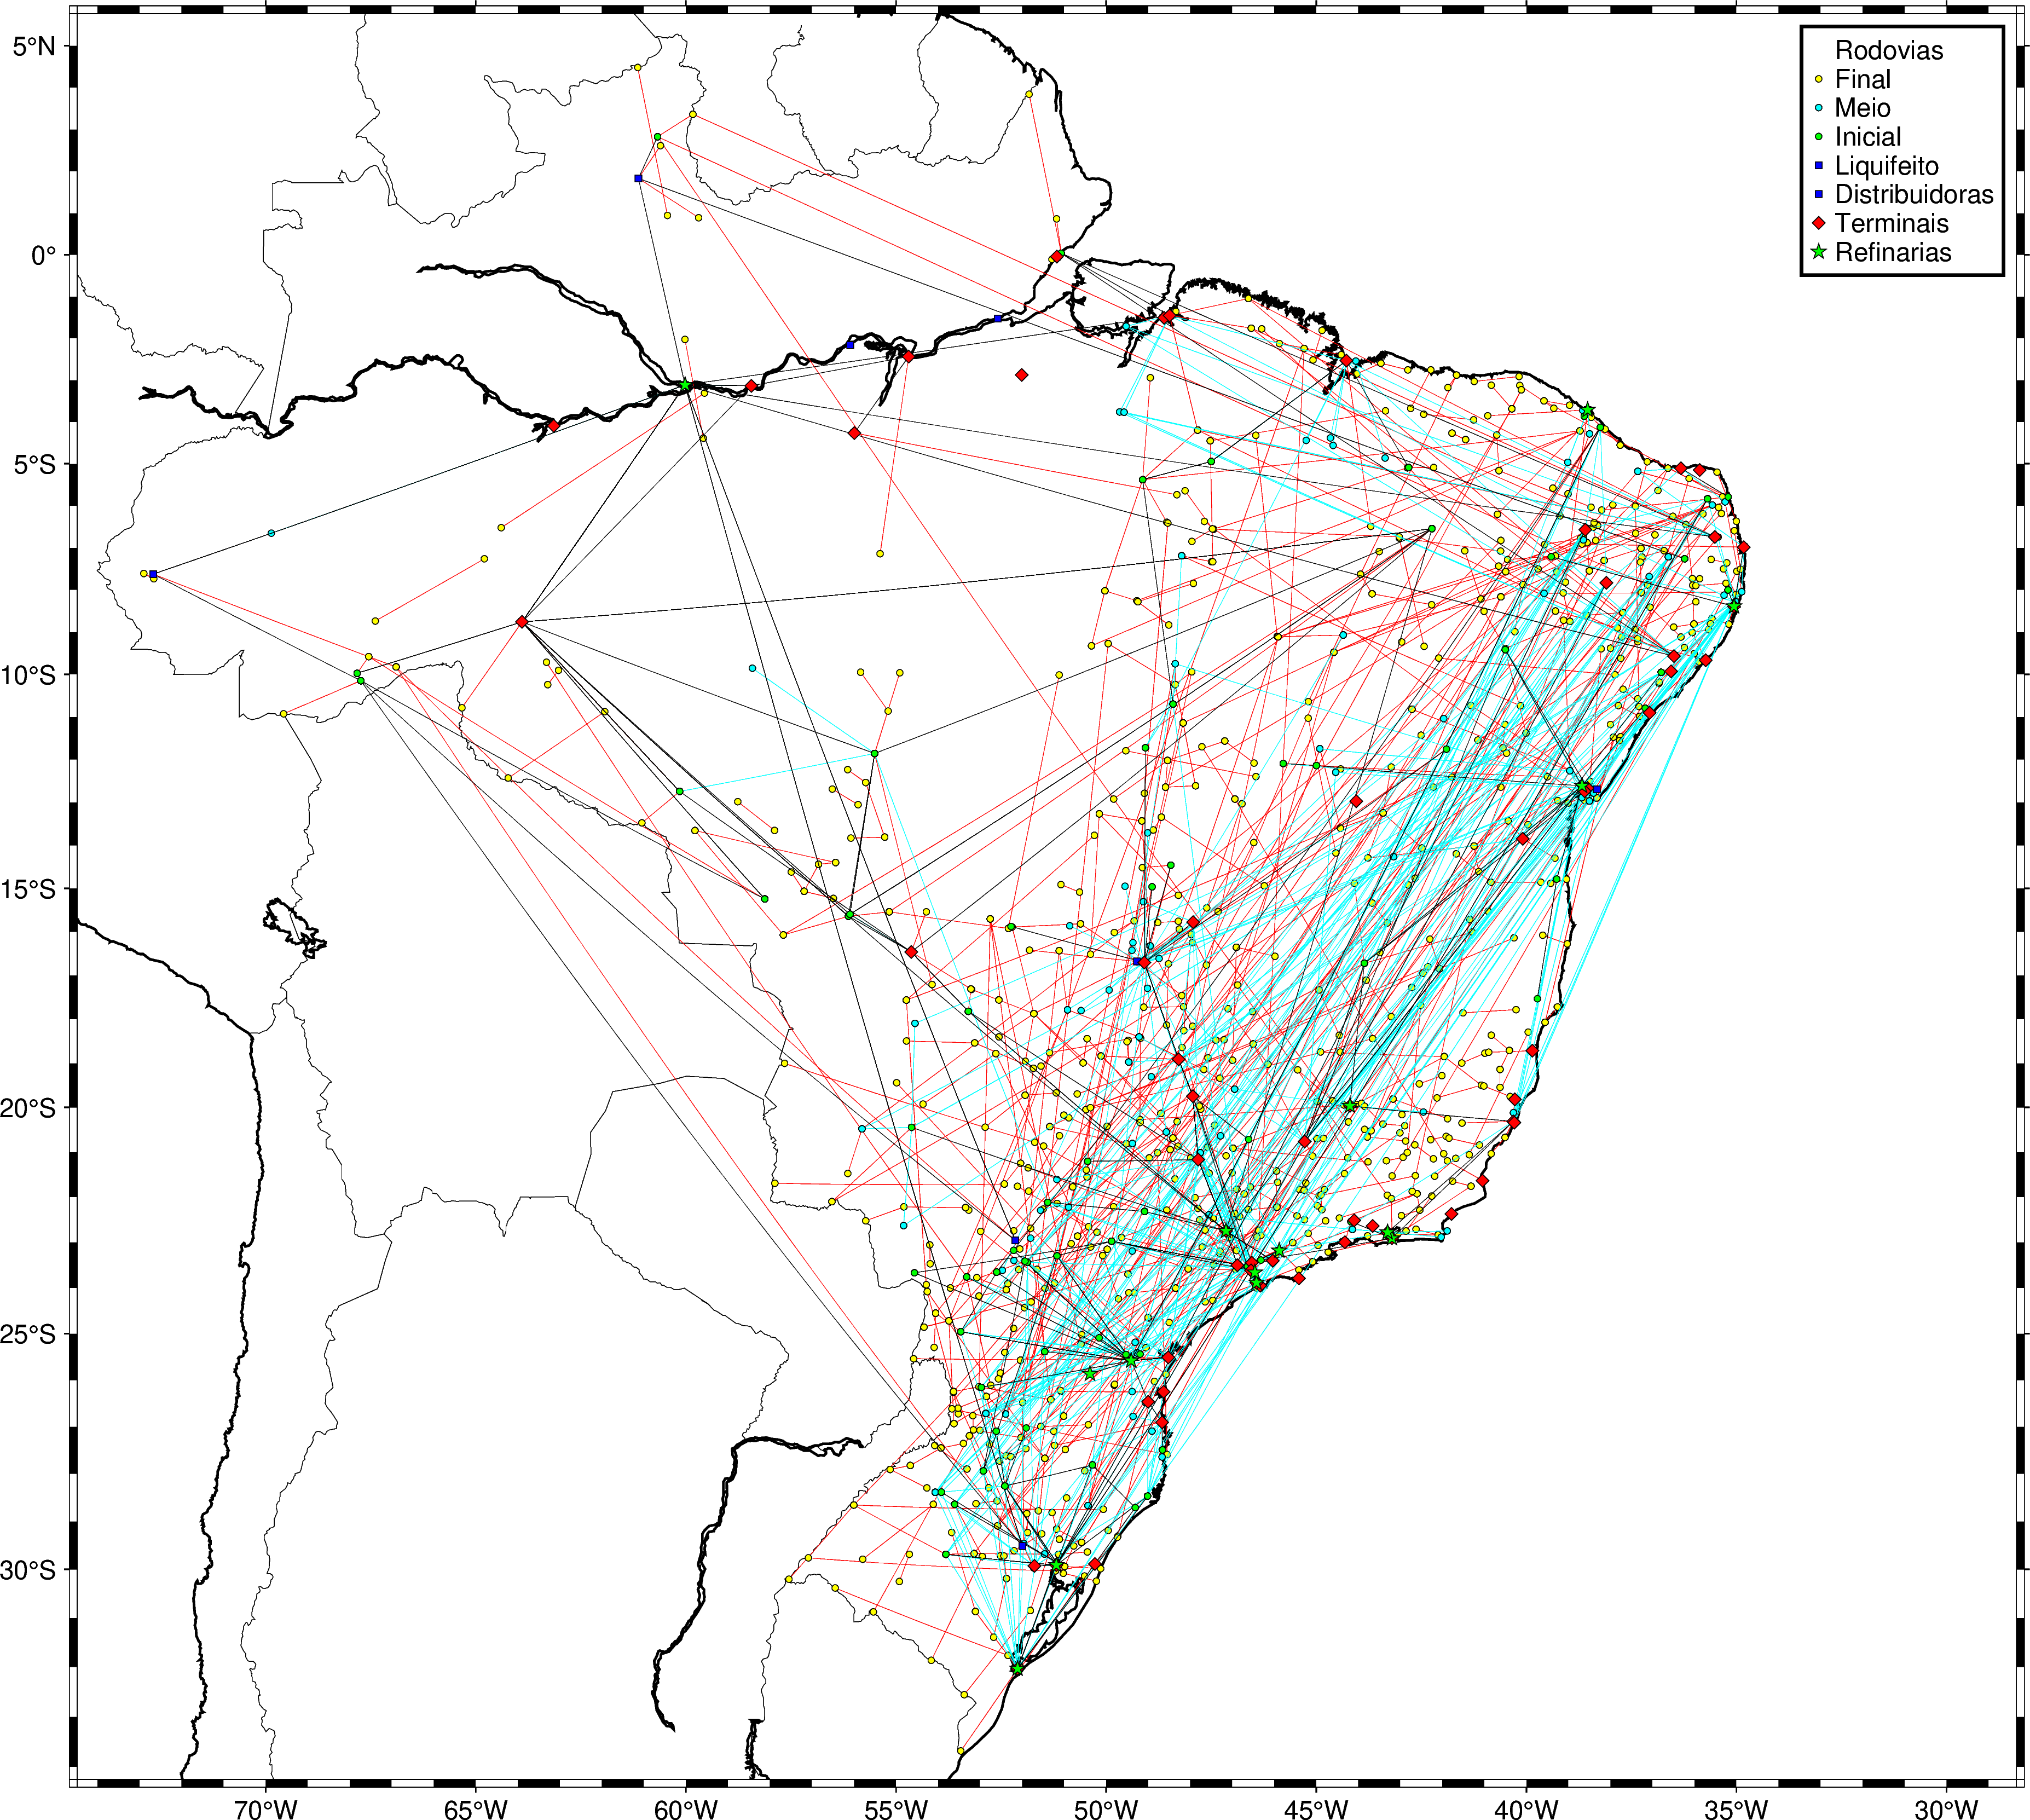

In [118]:
# create a plot with coast, Mercator projection (M) over the continental Brazil
fig = pygmt.Figure()

# Mapa do Brasil
fig.coast(
    #region=[-75, -34.5, -35, 8],
    region='BR+R0.5',
    #projection="B-55/-15/-25/0/48c",
    projection='M30c',
    frame=True,
    area_thresh=4000,
    shorelines="1p,black",
    borders = 1,
)

# # Postos de combustiveis e  Rodovias
style = "=0.1c+s+p0.1p,blue"
fig.plot(data=data_total_postos,          style=style, pen="0.15p,red",   label = 'Rodovias')
fig.plot(data=data_total_postos_pts,          style="c0.1c", color="yellow", pen="black", label='Final')

# Hidrovias
# fig.plot(data=data_hidro_simples,style=style, pen="0.15p,cyan")

# Meio da cadeia
fig.plot(data=data_gasol_diesel,          style=style, pen="0.15p,cyan")
fig.plot(data=data_gasol_diesel_pts,          style="c0.1c", color='cyan',   pen="black", label='Meio')

# Inicio da cadeia
fig.plot(data=data_corredor_gasol_diesel, style=style, pen="0.15p,black")
fig.plot(data=data_corredor_gasol_diesel_pts, style="c0.1c", color="green",  pen='black', label='Inicial')


# Distribuidoras de combustiveis liquidos
# fig.plot(data=data_distro, style="s0.25c", color="blue", label='Distribuidoras')

# Terminais
# fig.plot(data=data_terminais, style="d0.25c", color="red", label='Terminais')


# Oleodutos
# style = "=0.5c+s+e+a10+gblue+h0.25+p0.5p,blue"
# fig.plot(data=data_oleodutos, style=style, pen="0.5p,blue")

# fig.plot(data=origens_duto['CPQ'],  style="+0.1c", color="black", pen="black", label='CPQ')
# fig.plot(data=origens_duto['BOMB'],  style="+0.1c", color="black", pen="black", label='Bombeamento')
# fig.plot(data=origens_duto['LUB'],  style="+0.1c", color="black", pen="black", label='Lubrificantes')
# fig.plot(data=origens_duto['DUTO'],  style="+0.1c", color="black", pen="black", label='Dutovia')
# fig.plot(data=origens_duto['SOLV'],  style="+0.1c", color="black", pen="black", label='Solventes')
# fig.plot(data=origens_duto['ETAN'],  style="+0.1c", color="black", pen="black", label='Etanol')
# fig.plot(data=origens_duto['GLP'],  style="i0.15c", color="yellow", pen="black", label='GLP')
# fig.plot(data=origens_duto['GN'],  style="i0.15c", color="yellow", pen="black", label='GN')
fig.plot(data=origens_duto['LIQ'],  style="s0.15c", color="blue", pen="black", label='Liquifeito')
fig.plot(data=origens_duto['COMB'],  style="s0.15c", color="blue", pen="black", label='Distribuidoras')
fig.plot(data=origens_duto['TERM'], style="d0.2c", color="red", pen="black", label='Terminais')
fig.plot(data=origens_duto['REF'],  style="a0.25c", color="green", pen="black", label='Refinarias')

fig.legend(position="JTR+jTR+o0.2c", box=True)

fig.show()

In [83]:
# ================================== DESENHO DA REDE ============================================

nos =  733
arestas =  502
1.369713506139154
0.7394622505359232


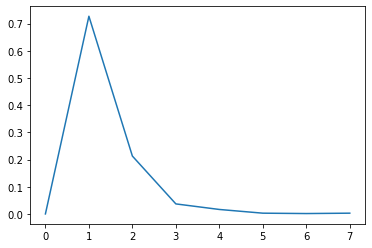

In [137]:
# G =   nx.from_pandas_edgelist(df_corredor_gasol_diesel, 'Municipio Origem', 'Municipio de Destino',create_using=nx.DiGraph()) # rede 01
# G =   nx.from_pandas_edgelist(df_gasol_diesel, 'Municipio Origem', 'Municipio de Destino',create_using=nx.DiGraph()) # rede 02
G =   nx.from_pandas_edgelist(df_rodo_CNT, 'Municipio Origem', 'Municipio de Destino')  # rede 03

print('nos = ', G.number_of_nodes())
print('arestas = ', G.number_of_edges())

degrees = np.array(G.degree)[:,1].astype(int)
print(degrees.mean())
print(degrees.std())

degree_count = nx.degree_histogram(G)
degree_prob = np.array(degree_count)/G.number_of_nodes()
# print(degree_prob)
plt.plot(degree_prob)



In [125]:
options = {
    'font_size': 8,
    'node_size': 10,
    'node_color': 'red',
    'edgecolors': 'black',
    'linewidths': .25,
    'width': .5,
}

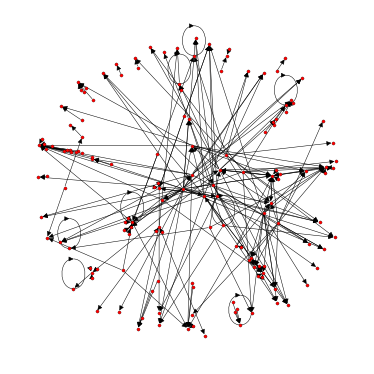

In [130]:
fig = plt.figure(figsize=(5, 5))
pos = nx.spring_layout(G, seed=123456789)  # Seed layout for reproducibility
nx.draw(G,  **options, with_labels=False)

NetworkXError: Found infinite path length because the graph is not connected

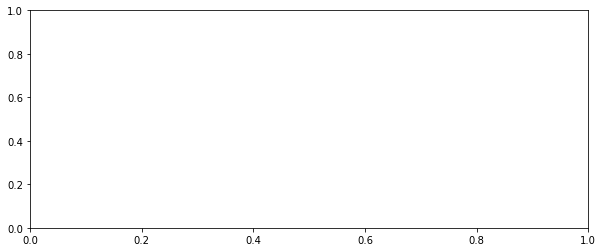

In [87]:
fig, ax = plt.subplots(1,figsize=(10,4))

# layout position
pos = nx.spring_layout(G, seed=123456789, k=0.3)
# color of nodes based on eccentricity
color = list(dict(nx.eccentricity(G)).values())

# draw edges
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_color=color,
                 cmap=plt.cm.jet, ax=ax)

# draw labels
nx.draw_networkx_labels(G, pos=pos,
                        font_color='white', ax=ax)
plt.colorbar(nodes, ax=ax)
ax.set_title("Grafo da excentricidade")

In [ ]:
print("Diâmetro da rede: {}".format(nx.diameter(G)))

NetworkXError: Found infinite path length because the graph is not connected

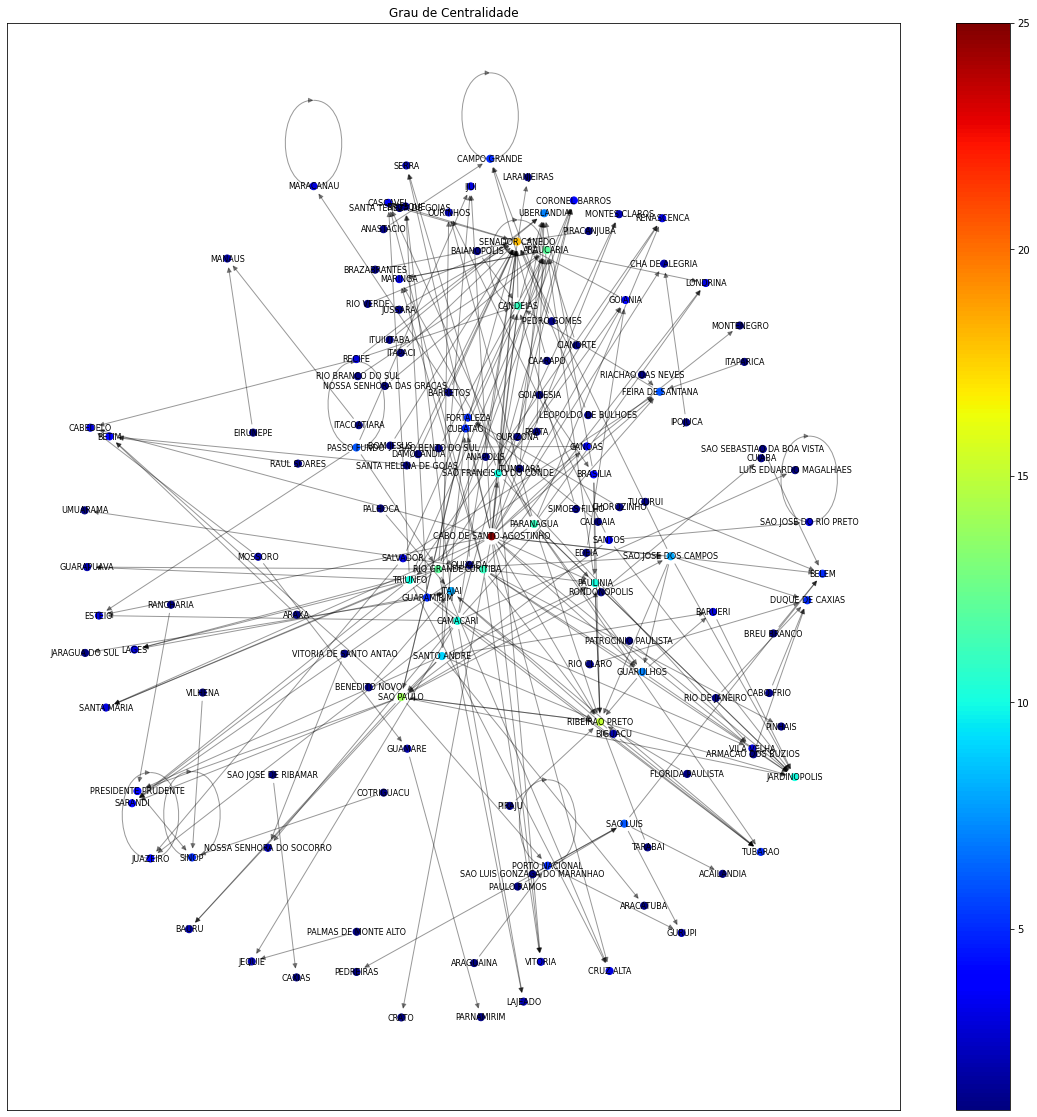

In [131]:
fig, ax = plt.subplots(1,figsize=(20,20))

# layout position
pos = nx.spring_layout(G,seed=123456789, k=0.3)
# color of nodes based on eccentricity
color = list(dict(nx.degree(G)).values())

# draw edges
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(G,
                 pos=pos,
                 node_size=50,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)

# draw labels
nx.draw_networkx_labels(G, pos=pos,
                        font_color='black', font_size=8, ax=ax)
plt.colorbar(nodes, ax=ax)
ax.set_title("Grau de Centralidade")
plt.show()

Text(0.5, 1.0, 'Centralidade de Intermediação')

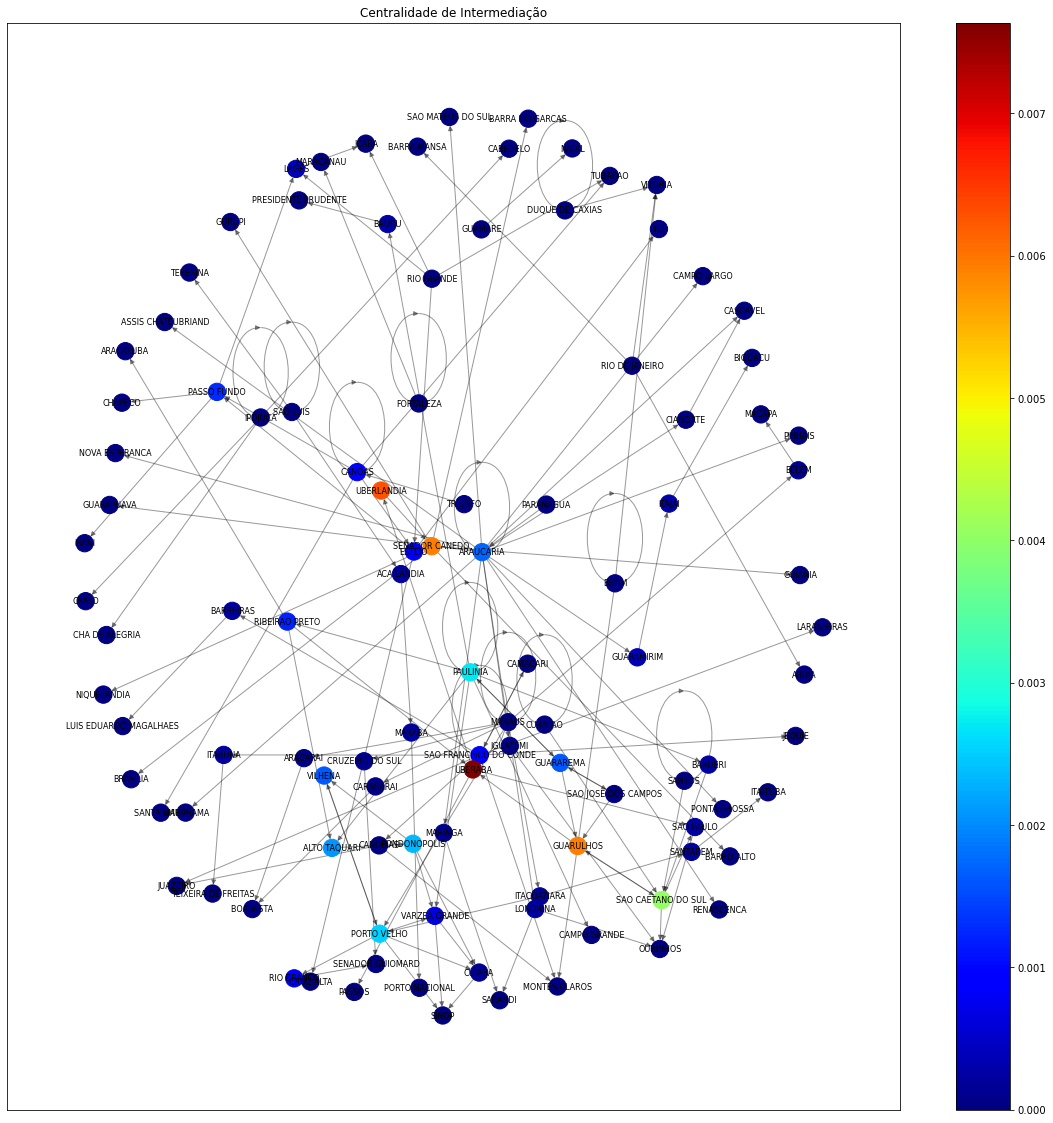

In [128]:
fig, ax = plt.subplots(1,figsize=(20,20))

# layout position
pos = nx.spring_layout(G,seed=123456789,k=0.3)
# color of nodes
color = list(dict(nx.betweenness_centrality(G)).values())

# draw edges
nx.draw_networkx_edges(G,
                       pos=pos,
                       alpha=0.4, ax=ax)

# draw nodes
nodes = nx.draw_networkx_nodes(G,
                 pos=pos, node_size=300,
                 node_color=color,
                 cmap=plt.cm.jet,ax=ax)

# draw labels
nx.draw_networkx_labels(G, pos=pos, font_size=8,
                        font_color='black', ax=ax)
plt.colorbar(nodes, ax=ax)
ax.set_title("Centralidade de Intermediação")

TypeError: plot got an unexpected keyword argument 'x'

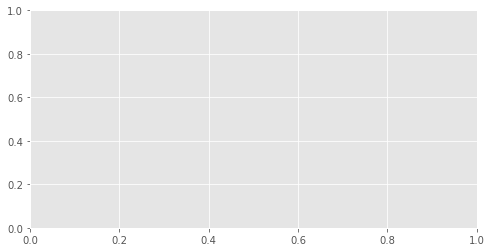

In [ ]:
plt.style.use("ggplot")
#plt.style.use("default")

fig, ax = plt.subplots(1,figsize=(8,4))

# degree sequence
degree_sequence = sorted([d for n, d in G.degree()], reverse=True) 

plt.plot(x=degree_sequence,y=[v for k,v in nx.betweenness_centrality(G).items()],ax=ax)
ax.set_xlabel("Grau")
ax.set_ylabel("Centralidade de Intermediação")
ax.set_title("Capitais")
ax.set_xlim(0,10)
ax.set_ylim(-0.01,0.5)
ax.grid(False)

plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555 entries, 0 to 554
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Ranking                   555 non-null    int64 
 1   Rodovia                   555 non-null    object
 2   Sobreposições existentes  555 non-null    object
 3   UF                        555 non-null    object
 4   Região                    555 non-null    object
 5   Municipio Origem          555 non-null    object
 6   Municipio de Destino      555 non-null    object
 7   Jurisdição                555 non-null    object
 8   Gestão                    555 non-null    object
 9   Extensão pesquisada (KM)  555 non-null    int64 
 10  Escalas de extensão       555 non-null    object
 11  Classificação geral       555 non-null    object
 12  Municipio                 555 non-null    object
 13  BANDEIRA                  555 non-null    int64 
 14  Municipio Destino         

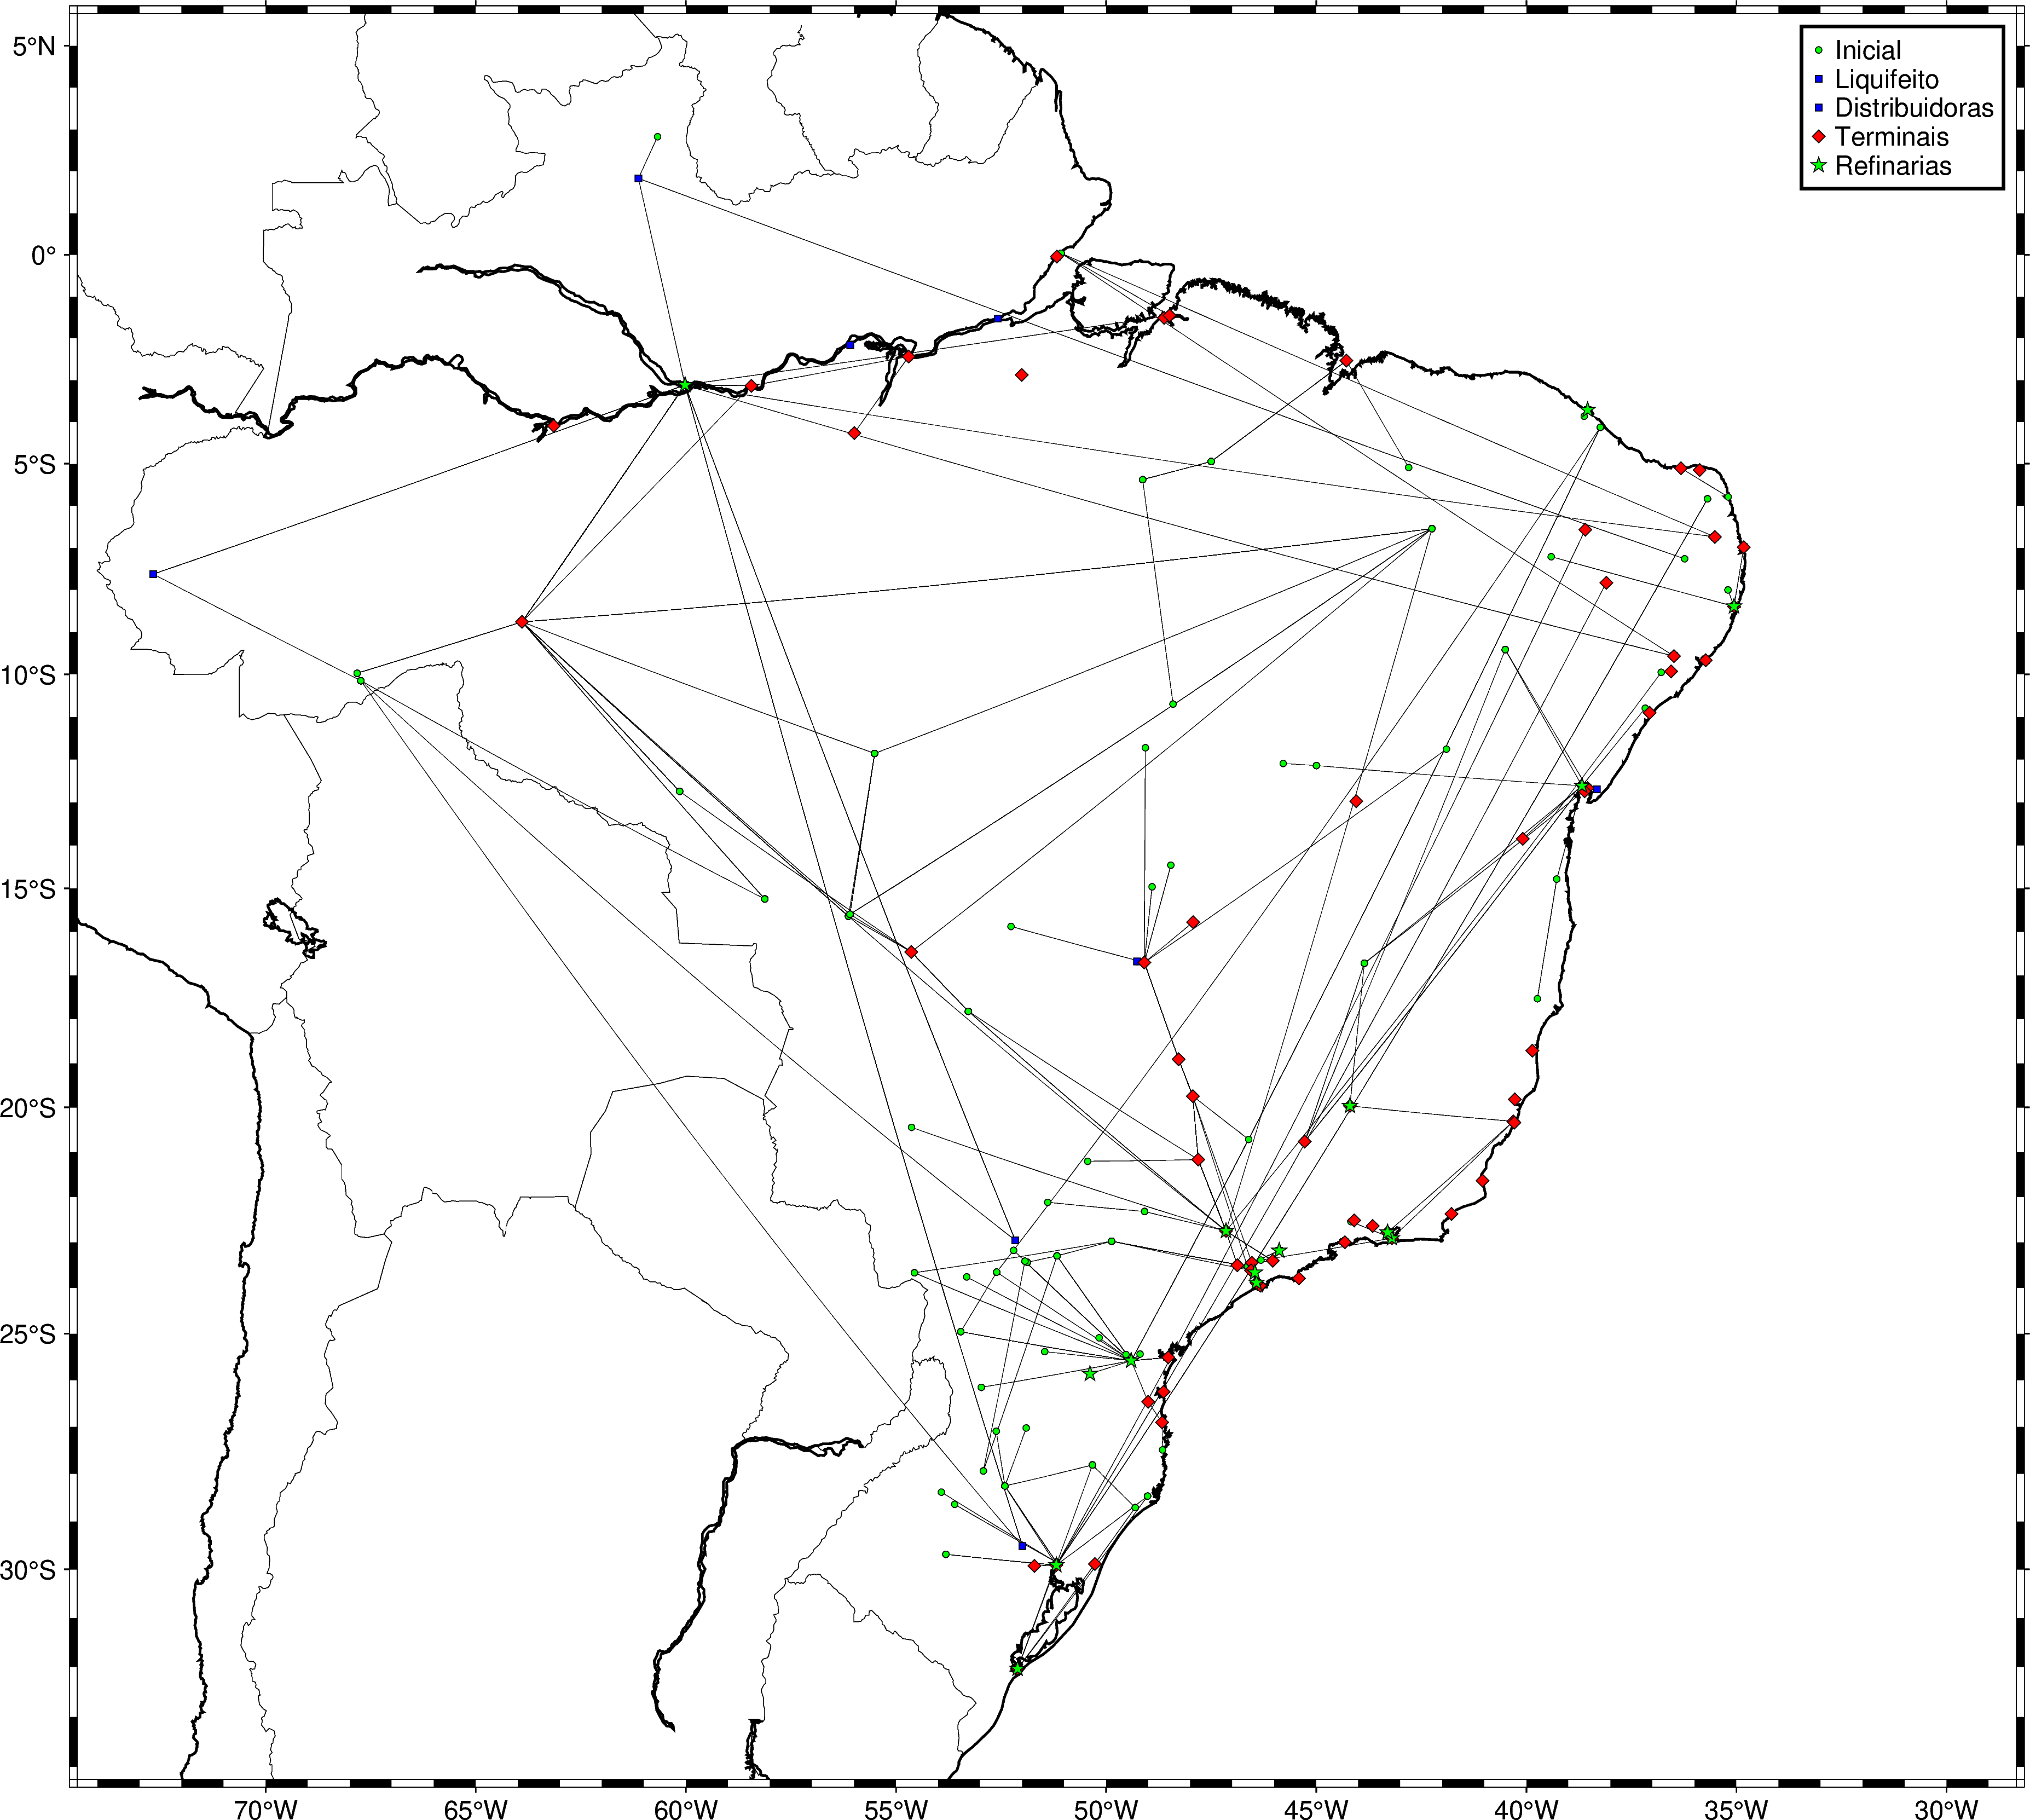

In [133]:
# create a plot with coast, Mercator projection (M) over the continental Brazil
fig = pygmt.Figure()

# Mapa do Brasil
fig.coast(
    region='BR+R0.5',
    projection='M30c',
    frame=True,
    area_thresh=4000,
    shorelines="1p,black",
    borders = 1,
)

# # Postos de combustiveis e  Rodovias
style = "=0.1c+s+p0.1p,blue"
# fig.plot(data=data_total_postos,          style=style, pen="0.15p,red",   label = 'Rodovias')
# fig.plot(data=data_total_postos_pts,          style="c0.1c", color="yellow", pen="black", label='Final')

# Meio da cadeia
# fig.plot(data=data_gasol_diesel,          style=style, pen="0.15p,cyan")
# fig.plot(data=data_gasol_diesel_pts,          style="c0.1c", color='cyan',   pen="black", label='Meio')

# Inicio da cadeia
fig.plot(data=data_corredor_gasol_diesel, style=style, pen="0.15p,black")
fig.plot(data=data_corredor_gasol_diesel_pts, style="c0.1c", color="green",  pen='black', label='Inicial')


fig.plot(data=origens_duto['LIQ'],  style="s0.15c", color="blue", pen="black", label='Liquifeito')
fig.plot(data=origens_duto['COMB'],  style="s0.15c", color="blue", pen="black", label='Distribuidoras')
fig.plot(data=origens_duto['TERM'], style="d0.2c", color="red", pen="black", label='Terminais')
fig.plot(data=origens_duto['REF'],  style="a0.25c", color="green", pen="black", label='Refinarias')

fig.legend(position="JTR+jTR+o0.2c", box=True)

fig.show()

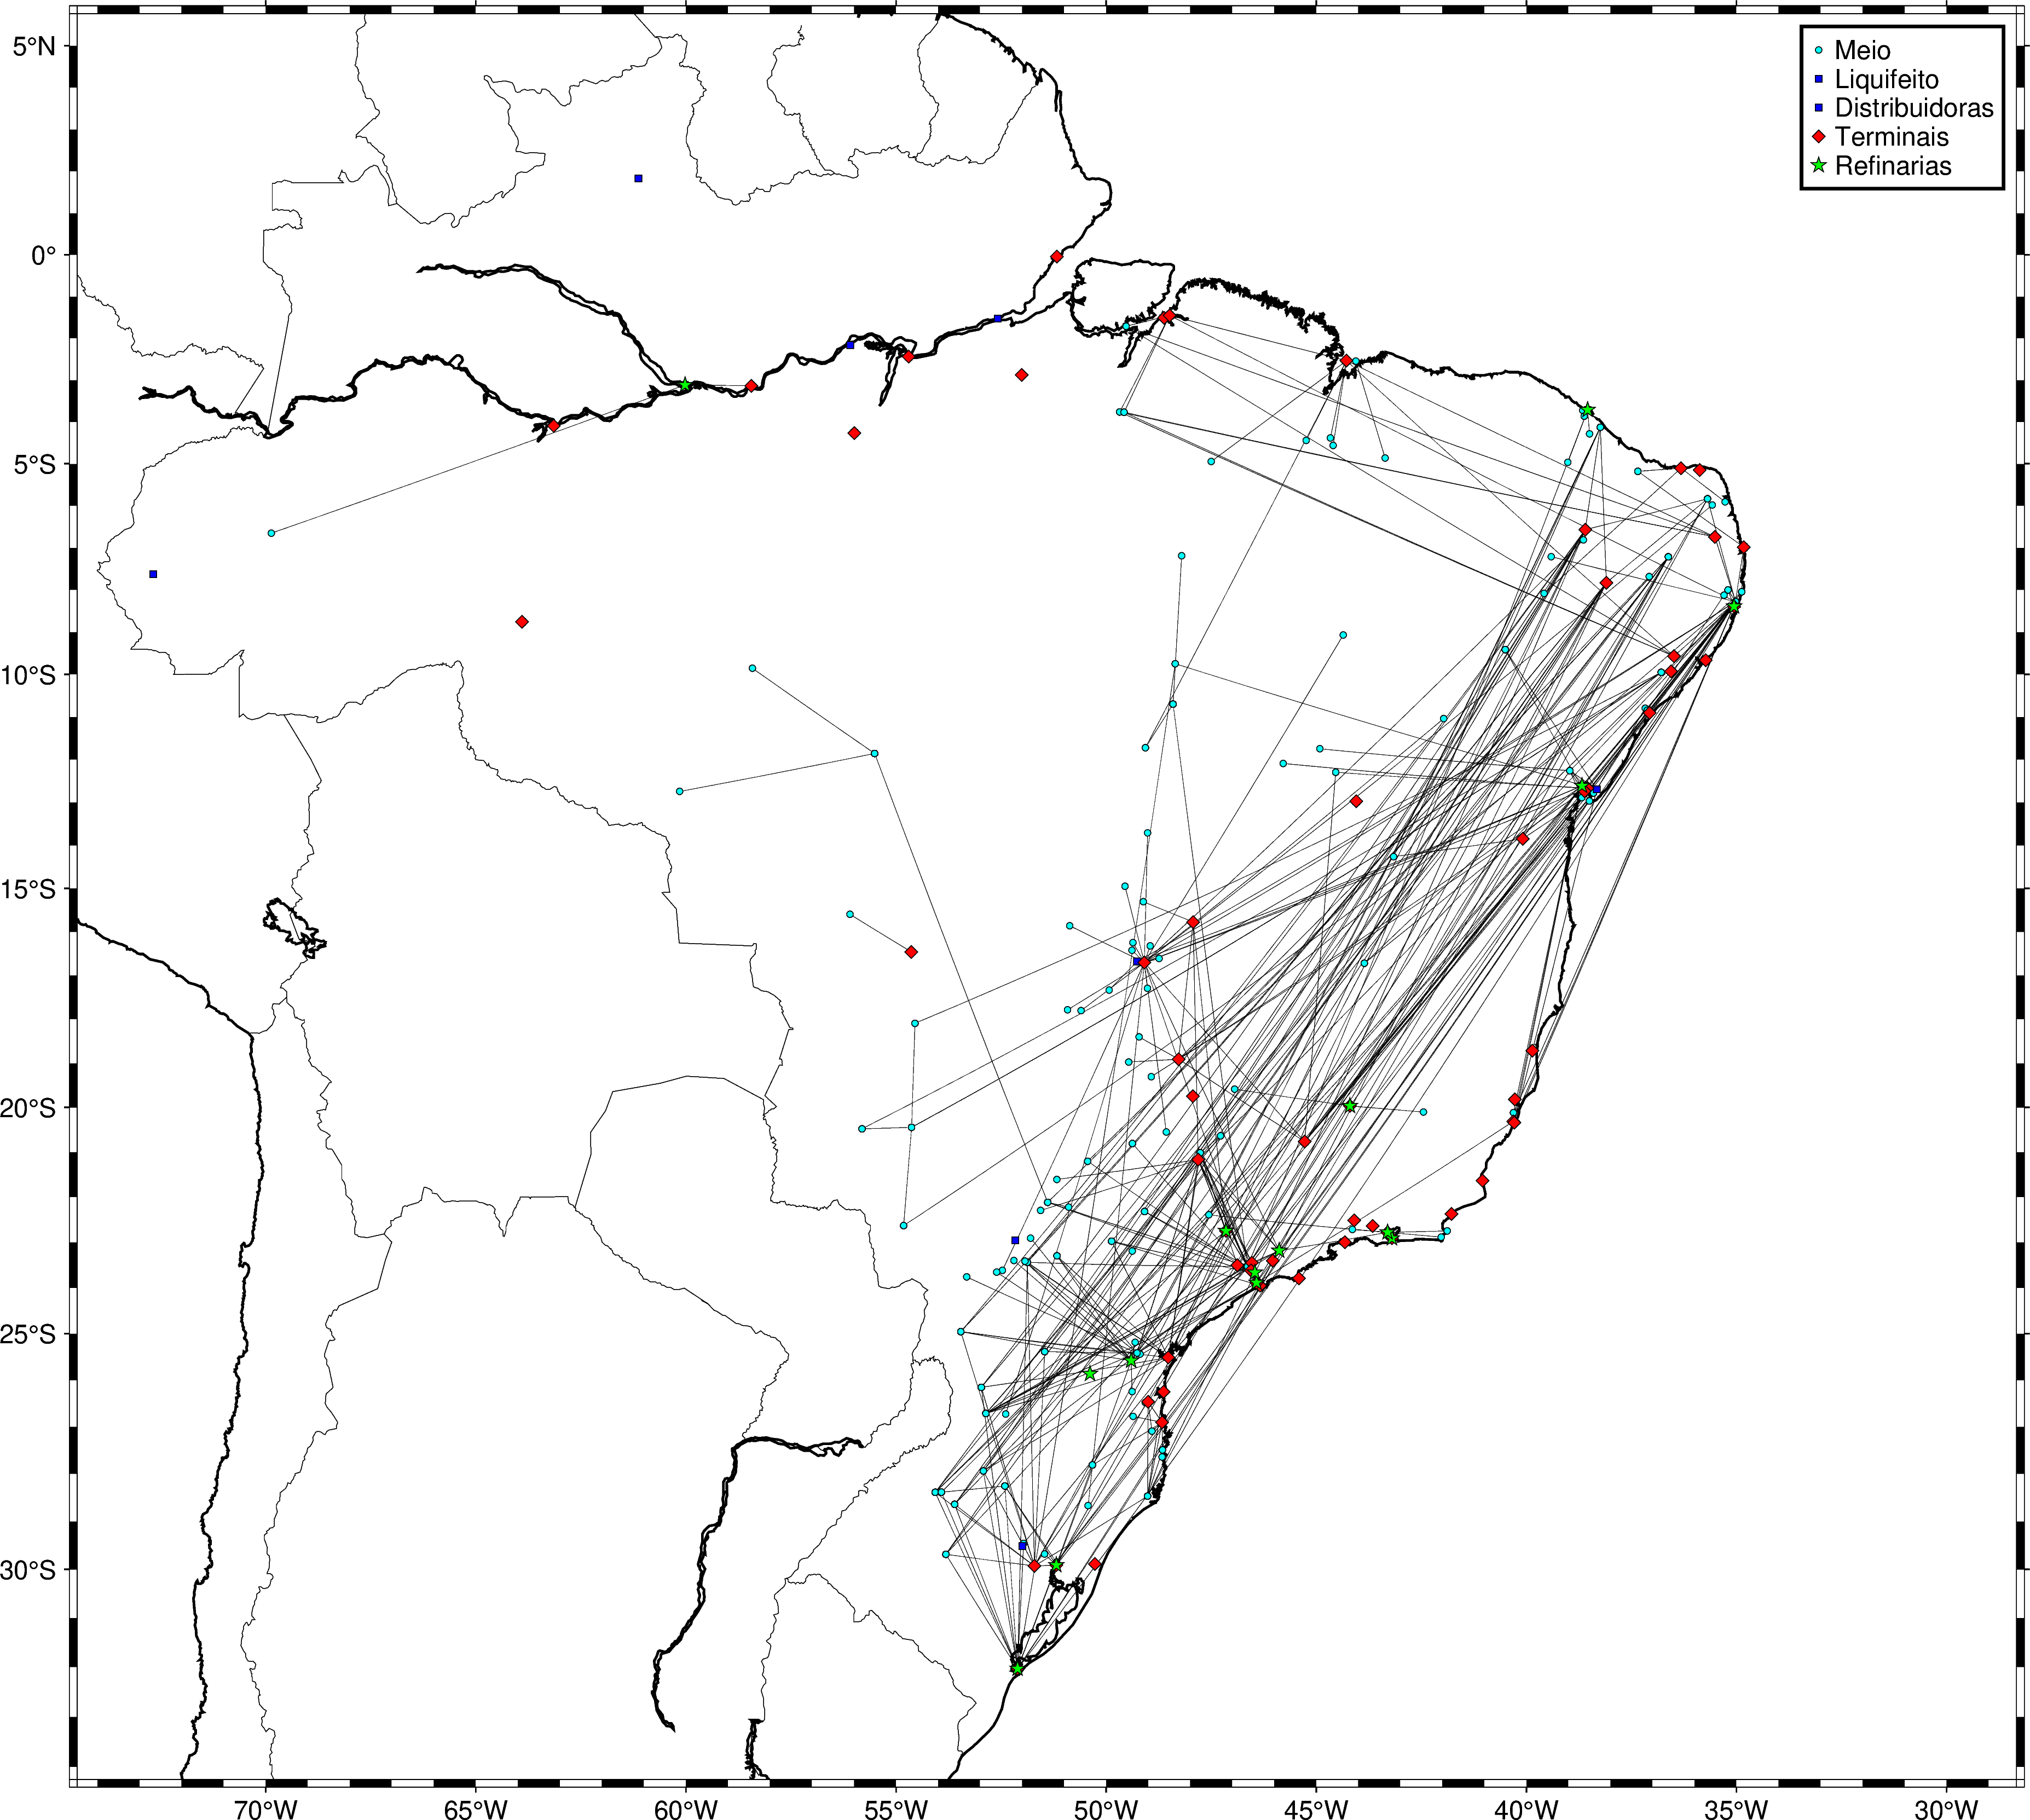

In [135]:
# create a plot with coast, Mercator projection (M) over the continental Brazil
fig = pygmt.Figure()

# Mapa do Brasil
fig.coast(
    region='BR+R0.5',
    projection='M30c',
    frame=True,
    area_thresh=4000,
    shorelines="1p,black",
    borders = 1,
)

# # Postos de combustiveis e  Rodovias
style = "=0.1c+s+p0.1p,blue"
# fig.plot(data=data_total_postos,          style=style, pen="0.15p,red",   label = 'Rodovias')
# fig.plot(data=data_total_postos_pts,          style="c0.1c", color="yellow", pen="black", label='Final')

# Meio da cadeia
fig.plot(data=data_gasol_diesel,          style=style, pen="0.1p,black")
fig.plot(data=data_gasol_diesel_pts,          style="c0.1c", color='cyan',   pen="black", label='Meio')

# Inicio da cadeia
# fig.plot(data=data_corredor_gasol_diesel, style=style, pen="0.15p,black")
# fig.plot(data=data_corredor_gasol_diesel_pts, style="c0.1c", color="green",  pen='black', label='Inicial')


fig.plot(data=origens_duto['LIQ'],  style="s0.15c", color="blue", pen="black", label='Liquifeito')
fig.plot(data=origens_duto['COMB'],  style="s0.15c", color="blue", pen="black", label='Distribuidoras')
fig.plot(data=origens_duto['TERM'], style="d0.2c", color="red", pen="black", label='Terminais')
fig.plot(data=origens_duto['REF'],  style="a0.25c", color="green", pen="black", label='Refinarias')

fig.legend(position="JTR+jTR+o0.2c", box=True)

fig.show()

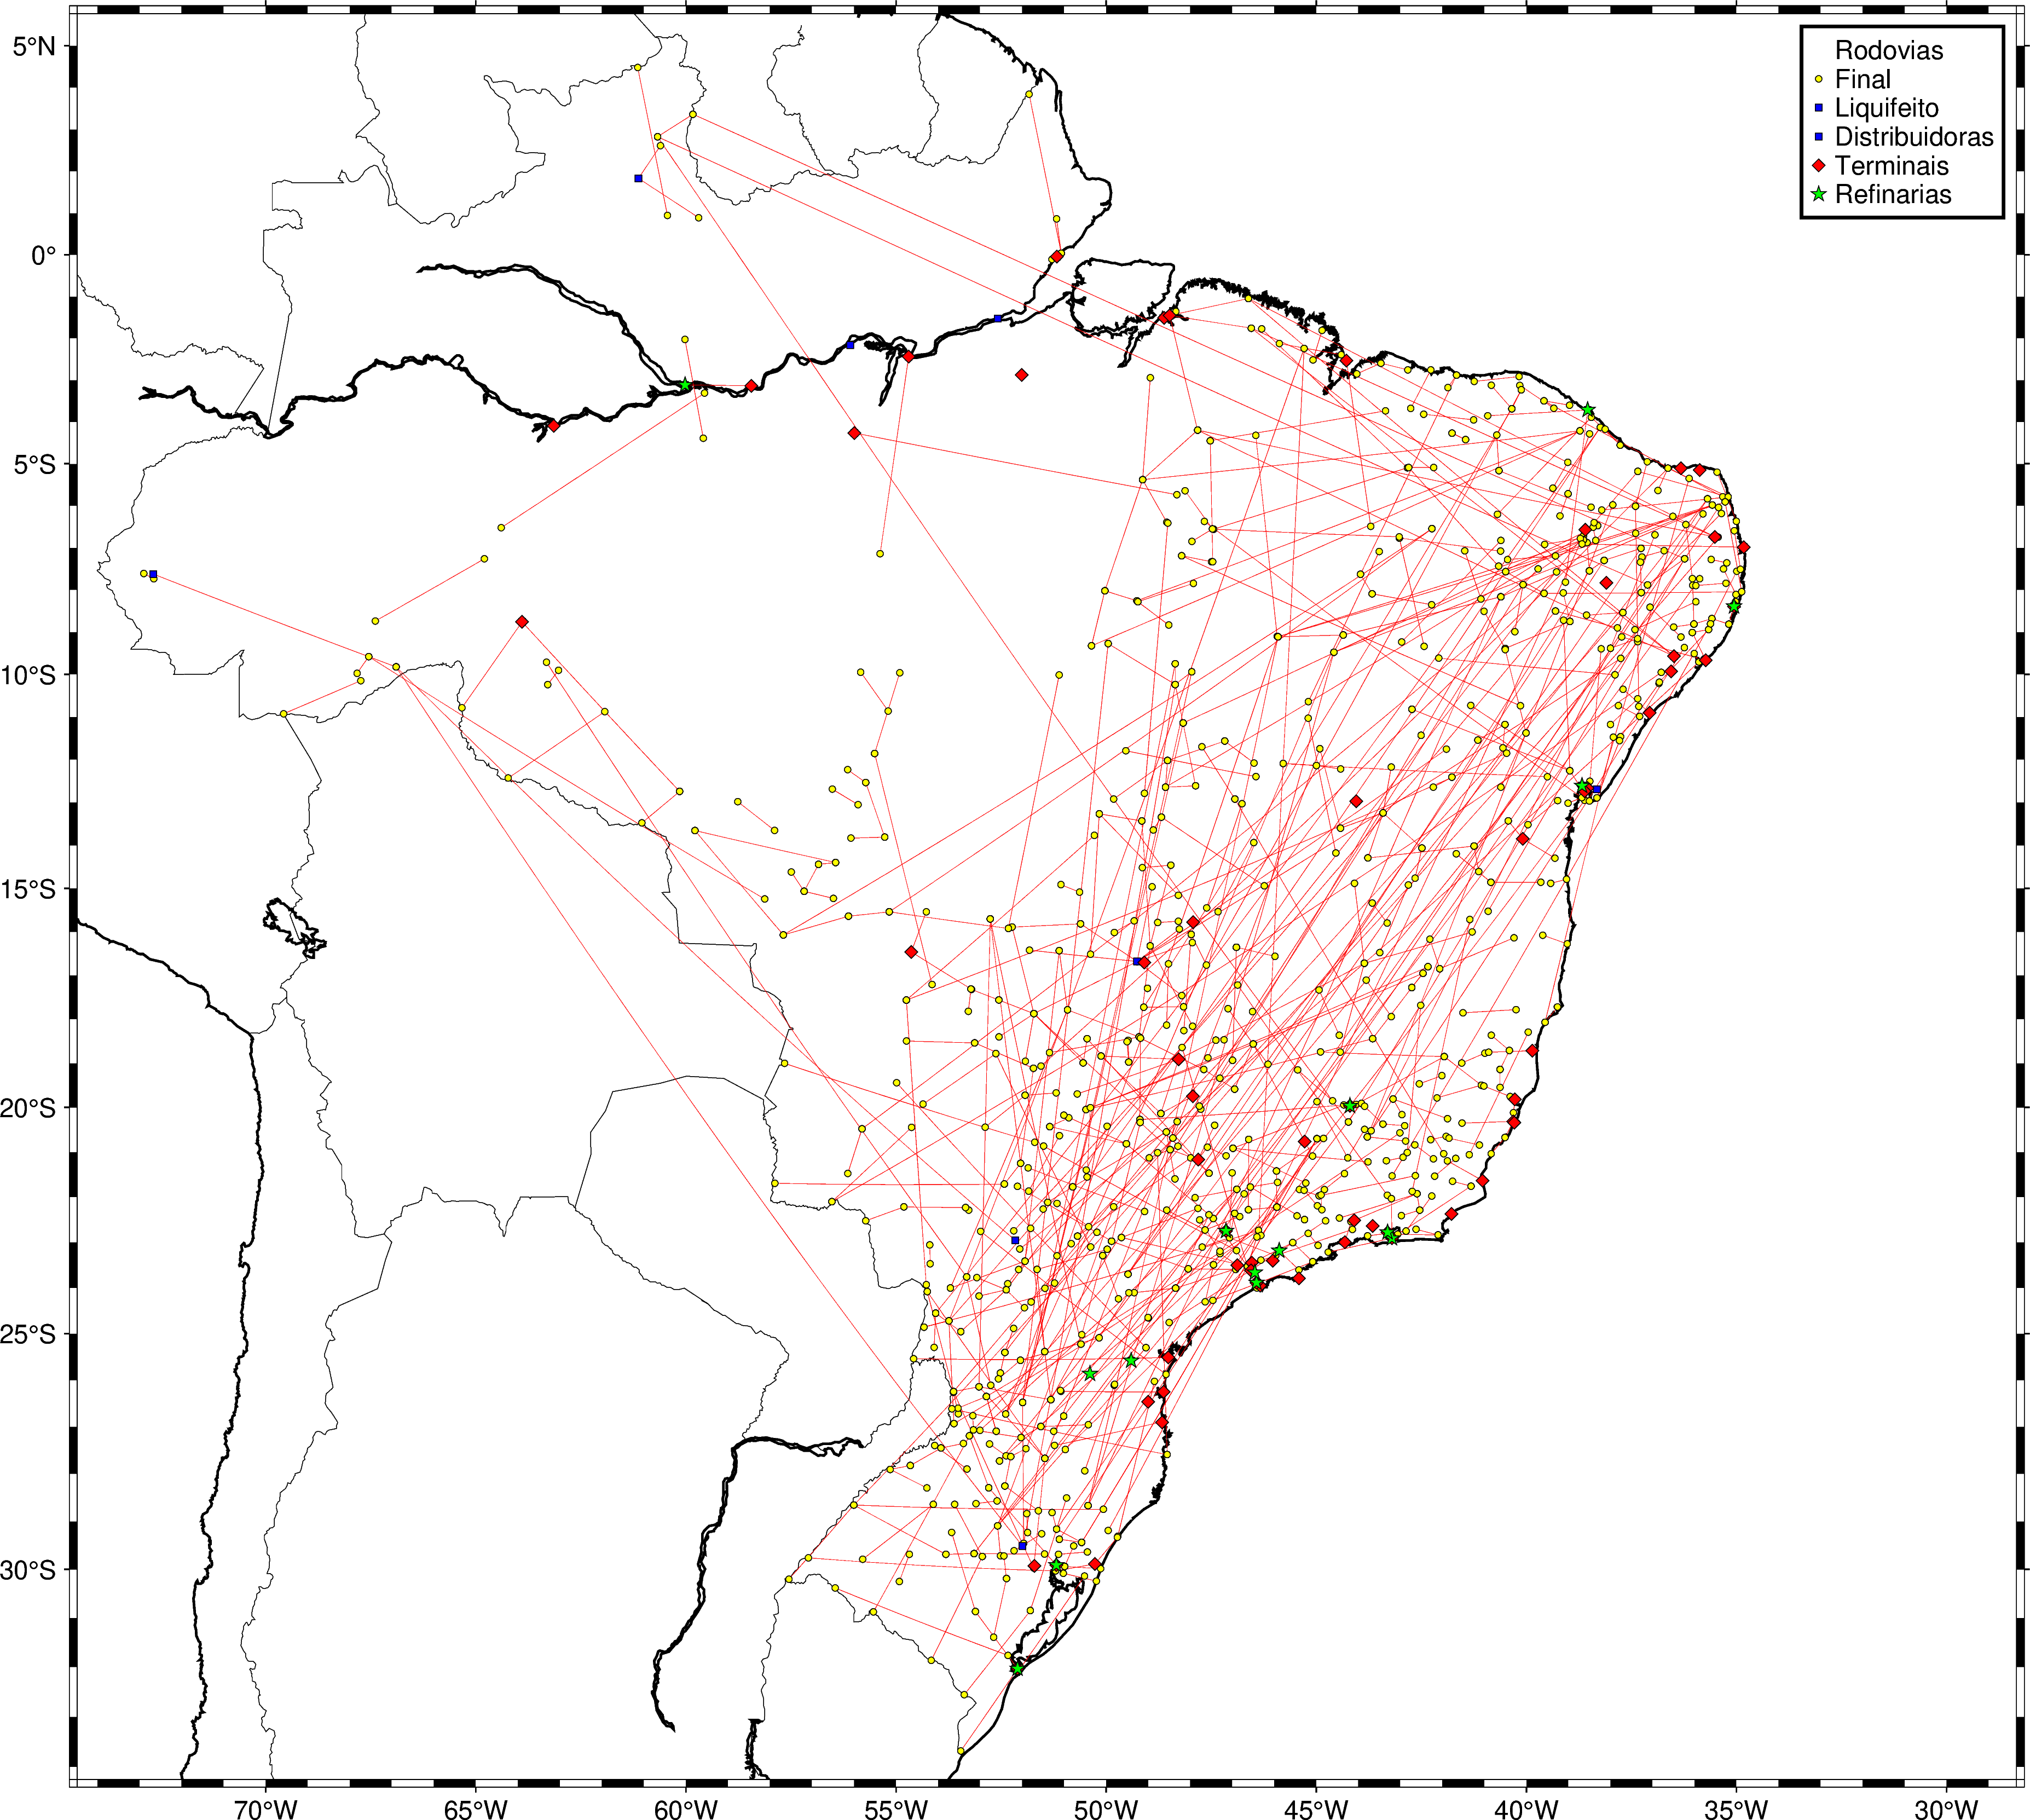

In [136]:
# create a plot with coast, Mercator projection (M) over the continental Brazil
fig = pygmt.Figure()

# Mapa do Brasil
fig.coast(
    region='BR+R0.5',
    projection='M30c',
    frame=True,
    area_thresh=4000,
    shorelines="1p,black",
    borders = 1,
)

# # Postos de combustiveis e  Rodovias
style = "=0.1c+s+p0.1p,blue"
fig.plot(data=data_total_postos,          style=style, pen="0.1p,red",   label = 'Rodovias')
fig.plot(data=data_total_postos_pts,          style="c0.1c", color="yellow", pen="black", label='Final')

# Meio da cadeia
# fig.plot(data=data_gasol_diesel,          style=style, pen="0.1p,black")
# fig.plot(data=data_gasol_diesel_pts,          style="c0.1c", color='cyan',   pen="black", label='Meio')

# Inicio da cadeia
# fig.plot(data=data_corredor_gasol_diesel, style=style, pen="0.15p,black")
# fig.plot(data=data_corredor_gasol_diesel_pts, style="c0.1c", color="green",  pen='black', label='Inicial')


fig.plot(data=origens_duto['LIQ'],  style="s0.15c", color="blue", pen="black", label='Liquifeito')
fig.plot(data=origens_duto['COMB'],  style="s0.15c", color="blue", pen="black", label='Distribuidoras')
fig.plot(data=origens_duto['TERM'], style="d0.2c", color="red", pen="black", label='Terminais')
fig.plot(data=origens_duto['REF'],  style="a0.25c", color="green", pen="black", label='Refinarias')

fig.legend(position="JTR+jTR+o0.2c", box=True)

fig.show()